# Matrix Factorization Recommendation Retrieval

In [ ]:
!pip install -q cornac==0.1.0.post5

In [25]:
import numpy as np
from numpy import *
import random
from collections import defaultdict
from operator import itemgetter
import time
import pickle
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.sparse as ss
from cornac.eval_methods import BaseMethod
from cornac.models import BPR, IBPR

**LSH Locality Sensitive Hashing - indexing for nearest neighbour searches in sublinear time**

simple tutorial implementation based on
A. Andoni and P. Indyk, "Near-optimal hashing algorithms for approximate nearest neighbor in high dimensions"
http://people.csail.mit.edu/indyk/p117-andoni.pdf

In [4]:
class LSHIndex:

    def __init__(self, hash_family, k, L):
        self.hash_family = hash_family
        self.k = k
        self.L = 0
        self.hash_tables = []
        self.resize(L)

    def resize(self, L):
        """ update the number of hash tables to be used """
        if L < self.L:
            self.hash_tables = self.hash_tables[:L]
        else:
            # initialise a new hash table for each hash function
            hash_funcs = [[self.hash_family.create_hash_func() for h in range(self.k)] for l in range(self.L, L)]
            self.hash_tables.extend([(g, defaultdict(lambda:[])) for g in hash_funcs])

    def hash(self, g, p):
        return self.hash_family.combine([h.hash(p) for h in g])

    def index(self, points):
        """ index the supplied points """
        self.points = points
        for g, table in self.hash_tables:
            for ix, p in enumerate(self.points):
                table[self.hash(g,p)].append(ix)
        # reset stats
        self.tot_touched = 0
        self.num_queries = 0

    def query(self, q, metric, max_results):
        """ find the max_results closest indexed points to q according to the supplied metric """
        candidates = set()
        for g, table in self.hash_tables:
            matches = table.get(self.hash(g,q), [])
            candidates.update(matches)
            
        # update stats
        self.tot_touched += len(candidates)
        self.num_queries += 1
        
        # rerank candidates
        candidates = [(ix, metric(q, self.points[ix])) for ix in candidates]
        candidates.sort(key = itemgetter(1))
        return candidates[:max_results]

    def get_avg_touched(self):
        """ mean number of candidates inspected per query """
        return self.tot_touched/self.num_queries


#################################################################################################
#--------------------------------- L2 LSH Hash Family ------------------------------------------#
#################################################################################################
class L2HashFamily:

    def __init__(self, w, d):
        self.w = w
        self.d = d

    def create_hash_func(self):
        # each L2Hash is initialised with a different random projection vector and offset
        return L2Hash(self.rand_vec(), self.rand_offset(), self.w)

    def rand_vec(self):
        return [random.gauss(0,1) for i in range(self.d)]

    def rand_offset(self):
        return random.uniform(0, self.w)

    def combine(self, hashes):
        """
        combine hash values naively with str()
        - in a real implementation we can mix the values so they map to integer keys
        into a conventional map table
        """
        return str(hashes)

class L2Hash:

    def __init__(self,r,b,w):
        self.r = r
        self.b = b
        self.w = w

    def hash(self, vec):
        return int((dot(vec, self.r) + self.b)/self.w)
	
	#--- inner product ---

def dot(u,v):
	return sum(ux * vx for ux, vx in zip(u,v))

#--- l2-norm---
def L2_norm(u,v):
	return sum((ux - vx)**2 for ux, vx in zip(u,v))**0.5

#################################################################################################
#--------------------------------- Cosine LSH Hash Family --------------------------------------#
#################################################################################################    
class CosineHashFamily:

    def __init__(self,d):
        self.d = d

    def create_hash_func(self):
        # each CosineHash is initialised with a random projection vector
        return CosineHash(self.rand_vec())

    def rand_vec(self):
        return [random.gauss(0,1) for i in range(self.d)]

    def combine(self, hashes):
        """ combine by treating as a bitvector """
        return sum(2**i if h > 0 else 0 for i,h in enumerate(hashes))
	
class CosineHash:

    def __init__(self, r):
        self.r = r

    def hash(self, vec):
        return self.sgn(dot(vec, self.r))

    def sgn(self,x):
        return int(x > 0)

#-- socine distance ---
def cosine_distance(u,v):
	return 1 - dot(u,v)/(dot(u,u)*dot(v,v))**0.5
	
    		
#################################################################################################
#--------------------------------- LSH Tester ------------------------------------------#
#################################################################################################
class LSHTester:
    """
    grid search over LSH parameters, evaluating by finding the specified
    number of nearest neighbours for the supplied queries from the supplied points
    """
    def __init__(self, points, queries, num_neighbours):
        self.points = points
        self.queries = queries
        self.num_neighbours = num_neighbours

    def run(self, name, metric, hash_family, k_vals, L_vals):
        """
        name: name of test
        metric: distance metric for nearest neighbour computation
        hash_family: hash family for LSH
        k_vals: numbers of hashes to concatenate in each hash function to try in grid search
        L_vals: numbers of hash functions/tables to try in grid search
        """
        exact_hits = [[ix for ix, dist in self.linear(q, metric, self.num_neighbours+1)] for q in self.queries]

        print(name)
        print('L \t k \t acc \t touch')
        for k in k_vals:        # concatenating more hash functions increases selectivity
            lsh = LSHIndex(hash_family, k, 0)
            for L in L_vals:    # using more hash tables increases recall
                lsh.resize(L)
                lsh.index(self.points)

                correct = 0
                for q,hits in zip(self.queries, exact_hits):
                    lsh_hits = [ix for ix, dist in lsh.query(q, metric, self.num_neighbours + 1)]
                    if lsh_hits == hits:
                        correct += 1
                print("{0}\t{1}\t{2}\t{3}".format(L, k, float(correct)/100, float(lsh.get_avg_touched())/len(self.points)))

    def linear(self, q, metric, max_results):
        """ brute force search by linear scan """
        candidates = [(ix, metric(q, p)) for ix,p in enumerate(self.points)]
        return sorted(candidates, key=itemgetter(1))[:max_results]    

In [5]:
class PMF(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)

        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors

        self.rmse_train = []
        self.rmse_test = []

    # ***Fit the model with train_tuple and evaluate RMSE on both train and test data.  ***********#
    # ***************** train_vec=TrainData, test_vec=TestData*************#
    def fit(self, train_vec, test_vec):
        # mean subtraction
        self.mean_inv = np.mean(train_vec[:, 2])  

        pairs_train = train_vec.shape[0]  # traindata 
        pairs_test = test_vec.shape[0]  # testdata

        # 1-p-i, 2-m-c
        num_user = int(max(np.amax(train_vec[:, 0]), np.amax(test_vec[:, 0]))) + 1  
        num_item = int(max(np.amax(train_vec[:, 1]), np.amax(test_vec[:, 1]))) + 1  

        incremental = False  
        if ((not incremental) or (self.w_Item is None)):
            # initialize
            self.epoch = 0
            self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)  
            self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)  

            self.w_Item_inc = np.zeros((num_item, self.num_feat))  
            self.w_User_inc = np.zeros((num_user, self.num_feat))  

        while self.epoch < self.maxepoch:  
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  

            # Batch update
            for batch in range(self.num_batches):  
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0]) 

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Objective Function
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],
                                              self.w_Item[batch_ItemID, :]),
                                  axis=1)  # mean_inv subtracted # np.multiply

                rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2] + self.mean_inv

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Objective Function after
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(train_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - train_vec[:, 2] + self.mean_inv
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(test_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(test_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - test_vec[:, 2] + self.mean_inv
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_test))

                    # Print info
                    if (self.epoch % 10 == 0):
                        print('Epoch: %d-th: Training RMSE %f, Test RMSE %f' % (self.epoch, self.rmse_train[-1], self.rmse_test[-1]))
        print("Done!")
        
    def predict(self, invID):
        return np.dot(self.w_Item, self.w_User[int(invID), :]) + self.mean_inv  # numpy.dot 点乘

    # ****************Set parameters by providing a parameter dictionary.  ***********#
    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)

    def topK(self, test_vec, k=10):
        inv_lst = np.unique(test_vec[:, 0])
        pred = {}
        for inv in inv_lst:
            if pred.get(inv, None) is None:
                pred[inv] = np.argsort(self.predict(inv))[-k:]  # numpy.argsort索引排序

        intersection_cnt = {}
        for i in range(test_vec.shape[0]):
            if test_vec[i, 1] in pred[test_vec[i, 0]]:
                intersection_cnt[test_vec[i, 0]] = intersection_cnt.get(test_vec[i, 0], 0) + 1
        invPairs_cnt = np.bincount(np.array(test_vec[:, 0], dtype='int32'))

        precision_acc = 0.0
        recall_acc = 0.0
        for inv in inv_lst:
            precision_acc += intersection_cnt.get(inv, 0) / float(k)
            recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])

        return precision_acc / len(inv_lst), recall_acc / len(inv_lst)


In [6]:
def evaluate_topK(test_data, data, queries, topK=10):
    inv_list = np.unique(test_data[:, 0]).astype(int)
    inv_list = [x for x in inv_list if x <= queries.shape[0]]
    rec_list = {}
    for inv in inv_list:
        if rec_list.get(inv, None) is None:
            rec_list[inv] = np.argsort(np.dot(data, queries[int(inv-1), :]))[-topK:]
    
    intersection_cnt = {}         
    for i in range(test_data.shape[0]):
        id = int(i)
        if int(test_data[id, 0]) in inv_list:
            if int(test_data[id, 1]) in rec_list[int(test_data[id, 0])]:
                intersection_cnt[test_data[id, 0]] = intersection_cnt.get(test_data[id, 0], 0) + 1
                
    invPairs_cnt = np.bincount(np.array(test_data[:, 0], dtype='int32'))

    precision_acc = 0.0
    recall_acc = 0.0
    for inv in inv_list:
        precision_acc += intersection_cnt.get(inv, 0) / float(topK)
        recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])

    return precision_acc / len(inv_list), recall_acc / len(inv_list)


def evaluate_LSHTopK(test_data, data, queries, lsh_index, metric, topK):          
    #build index
    lsh_index.index(data.tolist())

    inv_list = np.unique(test_data[:, 0]).astype(int)
    inv_list = [x for x in inv_list if x <= queries.shape[0]]

    rec_list = {}
    for inv in inv_list:
        if rec_list.get(inv, None) is None:
            rec_list[inv] = list(map(itemgetter(0), lsh_index.query(queries[inv-1, :], metric, topK)))
            
    intersection_cnt = {}         
    for i in range(test_data.shape[0]):
        id = int(i)
        if int(test_data[id, 0]) in inv_list:
            if int(test_data[id, 1]) in rec_list[int(test_data[id, 0])]:
                intersection_cnt[test_data[id, 0]] = intersection_cnt.get(test_data[id, 0], 0) + 1
                
    invPairs_cnt = np.bincount(np.array(test_data[:, 0], dtype='int32'))

    precision_acc = 0.0
    recall_acc = 0.0
    for inv in inv_list:
        precision_acc += intersection_cnt.get(inv, 0) / float(topK)
        recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])
    
    touched = float(lsh_index.get_avg_touched())/data.shape[0]
    
    return precision_acc / len(inv_list), recall_acc / len(inv_list), touched

In [ ]:
!wget https://raw.githubusercontent.com/sparsh-ai/rec-data-public/master/ml-1m-dat/ratings.dat

In [15]:
def load_rating_data(file_path):
    prefer = []
    for line in open(file_path, 'r'): 
        (userid, movieid, rating, ts) = line.split("::") 
        uid = int(userid)
        mid = int(movieid)
        rat = float(rating)
        prefer.append([uid, mid, rat])
        
    data = array(prefer)
    return data

# load movielens data
ratings = load_rating_data(file_path="ratings.dat")

In [16]:
# split data into train/test pair with 70/30 ratio
train, test = train_test_split(ratings, test_size = 0.3)

Train PMF algorithm with Movielens 1M dataset

#users: 6040 -- #items: 3706 -- #factors: 100
Epoch: 10-th: Training RMSE 1.088592, Test RMSE 1.106993
Epoch: 20-th: Training RMSE 0.961451, Test RMSE 0.996623
Epoch: 30-th: Training RMSE 0.886689, Test RMSE 0.934771
Epoch: 40-th: Training RMSE 0.851200, Test RMSE 0.911405
Epoch: 50-th: Training RMSE 0.824725, Test RMSE 0.897540
Epoch: 60-th: Training RMSE 0.802203, Test RMSE 0.888236
Epoch: 70-th: Training RMSE 0.781864, Test RMSE 0.881561
Epoch: 80-th: Training RMSE 0.762867, Test RMSE 0.876969
Epoch: 90-th: Training RMSE 0.745339, Test RMSE 0.873263
Epoch: 100-th: Training RMSE 0.729121, Test RMSE 0.871063
Done!


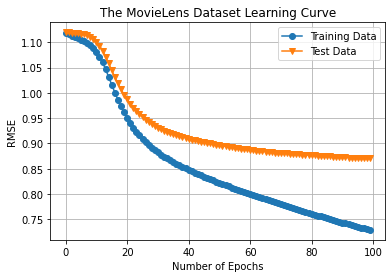

In [17]:
# learning from the training data
pmf = PMF()
pmf.set_params({"num_feat": 100, "epsilon": 1, "_lambda": 0.1, "maxepoch": 100, "num_batches": 100})
print("#users: {0} -- #items: {1} -- #factors: {2}".format(len(np.unique(ratings[:, 0])), len(np.unique(ratings[:, 1])), pmf.num_feat))

# training PMF with Movielens dataset
pmf.fit(train, test)

#Check performance by plotting train and test RMSE errors
plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
plt.title('The MovieLens Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#save model, training/testing data for future use
model_output = "pmf_mvl1m.model"
pickle.dump(pmf, open(model_output, 'wb'))
pickle.dump(train, open('train_data', 'wb'))
pickle.dump(test, open('test_data', 'wb'))

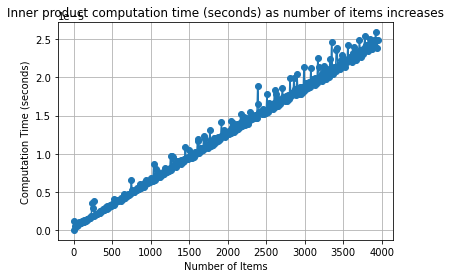

In [18]:
computation_time = []

data = pmf.w_Item
queries = pmf.w_User

#test queries
q = queries.T

for incr_size in range(0, data.shape[0], 10):
    start_time = time.time()
    pred = np.matmul(data[:incr_size, :], q)
    end_time   = time.time()
    computation_time.append((end_time - start_time)/q.shape[1])

#plot the computation time as the number of items increases
plt.plot(range(0, data.shape[0], 10), computation_time, marker='o', label='Computation_time')
plt.title('Inner product computation time (seconds) as number of items increases')
plt.xlabel('Number of Items')
plt.ylabel('Computation Time (seconds)')
plt.grid()
plt.show()

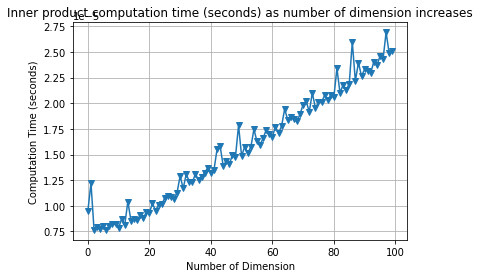

In [19]:
computation_time = []

for d in range(pmf.num_feat):
    start_time = time.time()
    
    # preference computation 
    pred = np.matmul(data[:incr_size, :d], q[:d, :])
    
    end_time   = time.time()
    
    #average the computation time 
    computation_time.append((end_time - start_time)/q.shape[1])

#plot the computation time as the number of dimension increases
plt.plot(range(pmf.num_feat), computation_time, marker='v', label='Computation_time')
plt.title('Inner product computation time (seconds) as number of dimension increases')
plt.xlabel('Number of Dimension')
plt.ylabel('Computation Time (seconds)')
plt.grid()
plt.show()

In [21]:
# measuring performance of the first 1000 users
topK = 10
data = pmf.w_Item
queries = pmf.w_User[:1000,:]

linear_prec, linear_recall = evaluate_topK(test, data, queries, topK)
print('linear_prec@{0} \t linear_recall@{0}'.format(topK))
print('{0}\t{1}'.format(linear_prec, linear_recall))

linear_prec@10 	 linear_recall@10
0.06340000000000034	0.020054711906920066


**Scalable Recommendation Retrieval with Locality Sensitive Hashing**

we can see that the cost of exhaustive search is linear to the number of items, i.e.,  𝑛  and number of features, i.e., 𝑑. In this part, we will practice to use Locality Sensitive Hashing to speed up the recommendation retrieval task.

One of the most popular search protocal using Locality Sensitive Hashing structure is Hashtable look-up. In this experiment, we build LSH index on the output of PMF algorithm. You should expect to see the precision and recall degeneration as compared to those of linear scanning solution. Here, we report three values:


1. relative_prec@10 = $\frac{\text{precision@10 of LSH Indexing}}{\text{precision@10 of linear scanning}}$ 
&nbsp;
&nbsp;
&nbsp;  
&nbsp;
2. relative_rec@10    = $\frac{\text{recall@10 of LSH Indexing}}{\text{recall@10 of linear scanning}}$
&nbsp;
&nbsp;
&nbsp;  
&nbsp;
3. touched = $\frac{\text{Average number of investigated items by LSH}}{\text{Total number of items}}$

**Without Transformation**

Since Xbox transformation augments user and item vectors to $(d+1)-$dimensional space. For comparison purpose, we append 0s to each user and item vector. 
\begin{equation}
P(y_i) = [y_i, 0] 
\end{equation}

\begin{equation}
Q(x_u) = [x_u, 0]
\end{equation}

With this transformation, we have:

\begin{equation}
Q(x_u)^T.P(y_i) = x_u^T.y_i
\end{equation}

In [22]:
same_queries = np.concatenate((queries, np.zeros((queries.shape[0], 1))), axis = 1)
same_data = np.concatenate((data, np.zeros((data.shape[0], 1))), axis = 1)

**With Xbox Transformation**

Now, before building LSH index, we first apply the Xbox transformation for both user and item vectors. This original maximum inner product search on the original representation becomes the maximum cosine similarity search on the new representation.

\begin{equation}
P(y_i) = [y_i, \sqrt{M^2 - ||y_i||^2}] (M = \max\{||y_i||\})
\end{equation}

\begin{equation}
Q(x_u) = [x_u, 0]
\end{equation}

We have the following observation:

\begin{equation}
\frac{Q(x_u)^T.P(y_i)}{||Q(x_u)||.||P(y_i)||} = \frac{x_u^T.y_i}{M.||x_u||}
\end{equation}

i.e., 

\begin{equation}
\arg\max_{1\leq i\leq n}{x_u^Ty_i} = \arg\max_{1\leq i\leq n}\frac{Q(x_u)^T.P(y_i)}{||Q(x_u)||.||P(y_i)||}
\end{equation}


We Xbox transformation, we effectively convert Maximum Inner Product Search (MIPS) problem to Maximum Cosine Similarity Search (MCCS).

In [23]:
#apply Xbox transformation
M = np.linalg.norm(data, axis=1) # compute item vector norms
max_norm = max(M) # max item norm

xbox_data = np.concatenate((data, np.sqrt(max_norm**2 - pow(M, 2)).reshape(data.shape[0], -1)), axis = 1)
xbox_queries = np.concatenate((queries, np.zeros((queries.shape[0], 1))), axis = 1)

## Comparing LSH performances with vs. without Xbox transformation

In [24]:
topK = 10 # top-K value
b_vals = [4, 6, 8] # number of hash function
L_vals = [5, 10] #number of hashtables

print('#table\t #bit\t ?Xbox \t relative_prec@{0} \t relative_recall@{0} \t touched'.format(topK))
for nt in L_vals:
    for b in b_vals: 
        #init lsh index:
        #------ hash-family: the LSH scheme/family 
        #------ k          : number of hash functions
        #------ L          : number of hash tables
        lsh_index = LSHIndex(hash_family = CosineHashFamily(same_data.shape[1]), k = b, L=nt)
        
        #performance without employing Xbox transformation
        print('---------------------------------------------------------------------------------')
        prec_1, recall_1, touched_1 = evaluate_LSHTopK(test, same_data, -same_queries, lsh_index, dot, topK)
        print("{0}\t{1}\t{2}\t{3}\t{4}\t{5}".format(nt, b, 'No',prec_1/linear_prec, recall_1/linear_recall, touched_1)) 
        
        #performance with Xbox transformation
        prec_2, recall_2, touched_2 = evaluate_LSHTopK(test, xbox_data, -xbox_queries, lsh_index, dot, topK)
        print("{0}\t{1}\t{2}\t{3}\t{4}\t{5}".format(nt, b, 'Yes', prec_2/linear_prec, recall_2/linear_recall, touched_2)) 

#table	 #bit	 ?Xbox 	 relative_prec@10 	 relative_recall@10 	 touched
---------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


5	4	No	0.6608832807570965	0.5827016112344234	0.2972193270933468
5	4	Yes	0.8675078864353312	0.8269844317240025	0.5437619529471288
---------------------------------------------------------------------------------
5	6	No	0.3028391167192412	0.24568748153797199	0.09735770301037187
5	6	Yes	0.36593059936908356	0.30873226383133634	0.1611588666835315
---------------------------------------------------------------------------------
5	8	No	0.2602523659305976	0.2238576790862026	0.029882367821907414
5	8	Yes	0.33123028391167025	0.30133031417662415	0.04907791550720971
---------------------------------------------------------------------------------
10	4	No	0.6608832807570967	0.5949584373567642	0.5172362762458892
10	4	Yes	0.7555205047318605	0.7250192180702495	0.6584857070579307
---------------------------------------------------------------------------------
10	6	No	0.463722397476339	0.3279682664817919	0.20243384771059955
10	6	Yes	0.541009463722396	0.4043668775086092	0.2918725018972932
---------------

## Indexable Representation Learning

Indexable representation refers to recommendation algorihtms whose latent vector representations are immediately sublinear searchable. In this tutorial, we are going to experiment with one of such models, namely Indexable Bayesian Personalized Ranking or IBPR for short.

In [29]:
eval_method = BaseMethod.from_provided(train_data=train, test_data=test,
                                       exclude_unknowns=False, verbose=True)

rec_bpr = BPR(k = 100, max_iter = 5, learning_rate=0.01, lamda=0.001, init_params={'U':None, 'V':None})
rec_bpr.fit(eval_method.train_set)

#number of recommendations
topK = 10

bpr_queries = rec_bpr.U
bpr_data    = rec_bpr.V

bpr_prec, bpr_recall = evaluate_topK(test, bpr_data, bpr_queries, topK)
print('bpr_prec@{0} \t bpr_recall@{0}'.format(topK))
print('{0}\t{1}'.format(bpr_prec, bpr_recall))

rating_threshold = 1.0
exclude_unknowns = False
Building training set
Number of training users = 6040
Number of training items = 3674
Max rating = 5.0
Min rating = 1.0
Global mean = 3.6
Building test set
Number of tested users = 6040
Number of unknown users = 0
Number of unknown items = 32
Shafling the data
epoch: 0 loss: tensor(452.4871, grad_fn=<SubBackward0>)
epoch: 1 loss: tensor(302.4047, grad_fn=<SubBackward0>)
epoch: 2 loss: tensor(89.1653, grad_fn=<SubBackward0>)
epoch: 3 loss: tensor(101.8558, grad_fn=<SubBackward0>)
epoch: 4 loss: tensor(96.0765, grad_fn=<SubBackward0>)
bpr_prec@10 	 bpr_recall@10
0.011423841059602704	0.002244938045930791


In [30]:
rec_ibpr = IBPR(k = 100, max_iter = 5, learning_rate = 0.01, lamda=0.001, init_params={'U':None, 'V':None})
rec_ibpr.fit(eval_method.train_set)

#number of recommendations
topK = 10

ibpr_queries = rec_ibpr.U
ibpr_data    = rec_ibpr.V

ibpr_prec, ibpr_recall = evaluate_topK(test, ibpr_data, ibpr_queries, topK)
print('ibpr_prec@{0} \t ibpr_recall@{0}'.format(topK))
print('{0}\t{1}'.format(ibpr_prec, ibpr_recall))

Shafling the data
epoch: 0 loss: tensor(74.0252, grad_fn=<SubBackward0>)
epoch: 1 loss: tensor(63.9967, grad_fn=<SubBackward0>)
epoch: 2 loss: tensor(55.4558, grad_fn=<SubBackward0>)
epoch: 3 loss: tensor(50.2685, grad_fn=<SubBackward0>)
epoch: 4 loss: tensor(45.0045, grad_fn=<SubBackward0>)
ibpr_prec@10 	 ibpr_recall@10
0.014768211920529717	0.0031803150451913315


In [31]:
topK = 10
b_vals = [4]
L_vals = [5]

print('#table\t #bit \t model \t prec@{0} \t recall@{0} \t touched'.format(topK))
for nt in L_vals:
    print('------------------------------------------------------------------------------')
    for b in b_vals: 
        lsh_index = LSHIndex(hash_family = CosineHashFamily(bpr_data.shape[1]), k = b, L = nt)
        
        lsh_bpr_prec, lsh_bpr_recall, touched_bpr = evaluate_LSHTopK(test, bpr_data, -bpr_queries, lsh_index, dot, topK)
        print("{0}\t{1}\t{2}\t{3}\t{4}\t{5}".format(nt, b, 'bpr', lsh_bpr_prec, lsh_bpr_recall, touched_bpr)) 

        lsh_ibpr_prec, lsh_ibpr_recall, touched_ibpr = evaluate_LSHTopK(test, ibpr_data, ibpr_queries, lsh_index, cosine_distance, topK)
        print("{0}\t{1}\t{2}\t{3}\t{4}\t{5}".format(nt, b, 'ibpr',lsh_ibpr_prec, lsh_ibpr_recall, touched_ibpr)) 


#table	 #bit 	 model 	 prec@10 	 recall@10 	 touched
------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


5	4	bpr	0.012483443708609272	0.0024496712125798817	0.29188741721854305
5	4	ibpr	0.014701986754966817	0.0031839277427409634	0.4483435597198138
